##### Установка зависимостей (делается один раз, потом иногда можно обновлять, но необязательно)

In [ ]:
# using Pkg

# # Pkg.add("JuMP")
# # Pkg.update("JuMP")
# # Pkg.add("HiGHS")
# # Pkg.add("EzXML")
# Pkg.add("Plots")

In [ ]:
using JuMP
using HiGHS
using EzXML
using Plots

### Параметры модели

In [ ]:
input = readlines("input/1")

# Количество слотов в одной тренировке (размер слота - 5 минут)
L = parse(Int64, input[1]) 

# Количество тренировочных дней (24 тренировки - 2 месяца)
D = parse(Int64, input[2]) 

# Количество тренировок в неделю
P = parse(Int64, input[3]) 

# Количество тренировочных недель
W = D ÷ P

# Получить номер недели по номеру дня
function w(d)
    return ((d-1) ÷ 7) + 1
end

# Игроки
I = parse(Int64, input[4]) 

# Упражнения
J = parse(Int64, input[5])  

# Классы упражнений
C = parse(Int64, input[6]) 

# Количество соревнований
Comp = parse(Int64, input[7])

# Дни соревнований
CompD = map(d -> parse(Int64, d), split(input[8]))

# Недели, соответствующие дням соревнований
CompW = map(d -> w(d), CompD)

# Длительность упражнений (t[j] - количество слотов, занимаемых упражнением j)
t = zeros(Int, J)
# принадлежность упражнения j к классу c (упражнение может быть полезным по разному)
alpha = zeros(Float16, C, J)
# названия упражнений
exName = Array{String, 1}(undef, J)
for j in 1:J
    exercise = split(input[9+j])
    t[j] = parse(Int64, exercise[1])
    for c in 1:C
        alpha[c, j] = parse(Float16, exercise[1+c])
    end
    exName[j] = exercise[1+C+1]
end

# потребность игрока i в упражнениях класса c
gamma = zeros(Float16, C, I)
# имя игрока
plName = Array{String, 1}(undef, I)
for i in 1:I
    player = split(input[9+J+1+i])
    for c in 1:C
        gamma[c, i] = parse(Float16, player[c])
    end
    plName[i] = player[C+1]
end

# присутствие игрока i в день d
a = zeros(Int, D, I)
for i in 1:I
    player = split(input[9+J+1+I+1+i])
    for d in 1:D
        a[d, i] = parse(Int, player[d])
    end
end

### Модель

In [ ]:
model = Model(HiGHS.Optimizer)

# f_ic(l_iwc/_l_iwc) - зависимость полезности упражнений класса c=1,2 для i-го игрока от соотношения набеганного времени к максимальному затребованному
function fitnessFatigue(x, c1, c2)
	if x >= 0 && x <= 0.1 + 0.2*c2
		return (((2+c1)/(2-c1))-((1+c2)/(3+2*c2)))*x
	elseif x <= 0.4 + 0.2*c1
		return (((2+c1)/(2-c1))+((9-2*c2)/(5-2*c2)))*x
	elseif x <= 1
		return (((2+c1)/(c1-2))+((9-2*c2)/(5-2*c2)))*x
	else
		return 0
	end
end

# на день d ставится упражнение j - xdj = 1, иначе - xdj = 0
@variable(model, x[d = 1:D, j = 1:J], binary = true)
# нижняя граница удовлетворенности игроков
@variable(model, S, lower_bound = 0)

f_lin(x) = x
f_ic = Array{Function, 2}(undef, I, C)
for i in 1:I
    for c in 1:C
		if c == 1 || c == 2
			f_ic[i, c] = fitnessFatigue
		else
			f_ic[i, c] = f_lin
		end
        
    end
end

# сколько i-ый игрок набегал за w-ую неделю упражнений класса c
l = Array{AffExpr, 3}(undef, I, W, C)
for i in 1:I
    for w in 1:W
        for c in 1:C
            l[i, w, c] = sum(sum(x[d, j]*a[d, i]*alpha[c, j]*t[j] for d in (w-1)*P+1:(w-1)*P+P) for j in 1:J)
        end
    end
end

# сколько i-ый игрок набегал бы если бы везде ходил и выполнял упражнения класса c ровно столько, сколько ему надо
l_ = Array{Float16, 3}(undef, I, W, C)
for i in 1:I
    for w in 1:W
        for c in 1:C
            l_[i, w, c] = sum(a[d, i]*gamma[c, i]*L for d in (w-1)*P+1:(w-1)*P+P)
        end
    end
end

# тренированность i-го игрока после w-ой недели
T = Array{AffExpr, 2}(undef, I, W)
for i in 1:I
    T[i, 1] = sum(f_ic[i, c](l[i, 1, c]/l_[i, w, c]) for c in 1:C)
    for w in 2:W
        T[i, w] = sum(f_ic[i, c](l[i, w, c]/l_[i, w, c]) for c in 1:C) + T[i, w - 1]
    end
end

# Недели дней соревнований (тренированность i-го игрока в недели соревнований)
T_comp = Array{AffExpr, 2}(undef, I, Comp)
for i in 1:I
    for j in 1:Comp
        T_comp[i, j] = T[i, CompW[j]]
    end
end

# целевая эффективность тренировочного процесса для i-го игрока относительно соревнований
S_i = Array{AffExpr, 1}(undef, I)
for i in 1:I
    S_i[i] = sum(T_comp[i, w] for w in CompW) #/ (maximum(T_comp[i, w] for w in 1:Comp) - maximum(T_comp[i, w] for w in 1:Comp))
end

# в каждый момент времени идет только одно упражнение
@constraint(model, [d = 1:D], sum(x[d, j]*t[j] for j in 1:J) <= L)
# минимальная удовлетворенность не ниже порога
@constraint(model, [i = 1:I], S_i[i] >= S)

@objective(model, Max, S)

optimize!(model)


### Расчет оптимального значения для каждого по отдельности

In [ ]:
# l_ = Array{Float16, 3}(undef, I, W, C)
# for i in 1:I
#     for w in 1:W
#         for c in 1:C
#             l_[i, w, c] = sum(a[d, i]*gamma[c, i]*L for d in (w-1)*P+1:(w-1)*P+P)
#         end
#     end
# end
T_ = Array{Float16, 2}(undef, I, W)
for i in 1:I
    T_[i, 1] = sum(f_ic[i, c](l_[i, 1, c]) for c in 1:C)
    for w in 2:W
        T_[i, w] = sum(f_ic[i, c](l_[i, w, c]) for c in 1:C) + T_[i, w - 1]
    end
end
T_comp_ = Array{Float16, 2}(undef, I, Comp)
for i in 1:I
    for j in 1:Comp
        T_comp_[i, j] = T_[i, CompW[j]]
    end
end
S_i_ = Array{Float16, 1}(undef, I)
for i in 1:I
    S_i_[i] = sum(T_comp_[i, w] for w in CompW)
end

### Результаты

На день 1 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 2 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 3 ставим упражнения: Прыгать БросатьМячик 
На день 4 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 5 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 6 ставим упражнения: Бегать Веселиться БросатьМячик 
На день 7 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 8 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 9 ставим упражнения: 
На день 10 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 11 ставим упражнения: Прыгать Грустить БросатьМячик 
На день 12 ставим упражнения: БросатьМячик 
Минимальная удовлетворенность: 672.0546875


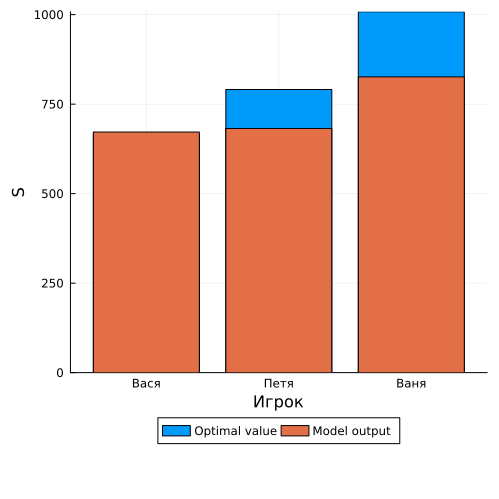

In [ ]:
for d in 1:D
    print("На день $(d) ставим упражнения: ")
    for j in 1:J
        if value(x[d, j]) == 1
            print("$(exName[j]) ")
        end
    end
    println()
end

println("Минимальная удовлетворенность: $(value(S))")

gr(size = (500, 500), legend = false)
Sval_i = map(val -> value(val), S_i)
plot = bar(plName, S_i_, label="Optimal value")
plot = bar!(plName, Sval_i, label="Model output")
xlabel!(plot, "Игрок")
ylabel!(plot, "S")
plot!(legend=:outerbottom, legendcolumns=2)
plot